In [1]:
%matplotlib widget

In [2]:
import pycomlink as pycml
import numpy as np

In [3]:
cml_list = pycml.io.examples.get_75_cmls()

100%|██████████| 75/75 [00:00<00:00, 75.32it/s]


In [4]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

In [5]:
cml.trsl.plot.line(x='time', figsize=(10,3));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Wet-dry classification using rolling std-dev and CNN method

In [6]:
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > 0.8

In [7]:
from pycomlink.processing.wet_dry.cnn import cnn_wet_dry

wet_cnn = cnn_wet_dry(
    trsl_channel_1=cml.trsl.isel(channel_id=0),
    trsl_channel_2=cml.trsl.isel(channel_id=1),
)
cml['wet_cnn'] = (('channel_id', 'time'), np.stack([wet_cnn, wet_cnn]))

/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chwala

/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chwala-c/mambaforge/envs/pycomlink-dev/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 2674)
Coordinates:
  * time              (time) datetime64[ns] 2017-06-28T00:00:08.354864128 ......
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    cml_id            |S17 b'SY5903_2_SY5797_3'
    site_a_latitude   float64 50.31
    site_b_latitude   float64 50.32
    site_a_longitude  float64 50.4
    site_b_longitude  float64 50.32
    frequency         (channel_id) float64 38.68 37.42
    polarization      |S1 b'V'
    length            float64 2.673
Data variables:
    tsl               (channel_id, time) float64 10.0 10.0 10.0 ... 10.0 10.0
    rsl               (channel_id, time) float64 -42.6 -42.6 ... -41.6 -41.6
    trsl              (channel_id, time) float64 52.6 52.6 52.6 ... 51.6 51.6
    wet               (channel_id, time) bool False False False ... False False
    wet_cnn           (channel_id, time) float64 nan nan nan nan ... nan nan nan

In [10]:
import matplotlib.pyplot as plt

#cml = cml_list[0]
#cml['trsl'] = cml.tsl - cml.rsl

fig, ax = plt.subplots(3, 1, figsize=(12,5), sharex=True)

cml.trsl.plot.line(x='time', ax=ax[0])
cml.wet_cnn.plot.line(x='time', ax=ax[1])
(cml.trsl.rolling(time=60, center=True).std()).plot.line(x='time', ax=ax[2])
ax[0].set_title('trsl')
ax[1].set_title('cnn wet-dry')
ax[2].set_title('rolling std_dev');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
fig, ax = plt.subplots(figsize=(10,3))

cml['baseline'] = pycml.processing.baseline.baseline_constant(rsl=cml.trsl, wet=cml.wet)
cml.trsl.plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.plot.line(x='time');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)

plt.sca(axs[0])
cml['baseline'] = pycml.processing.baseline.baseline_constant(rsl=cml.trsl, wet=cml.wet)
cml.trsl.plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.plot.line(x='time', linestyle=':');
plt.gca().set_prop_cycle(None)
(cml.baseline + cml.waa).plot.line(x='time');
plt.ylabel('TRSL')

plt.sca(axs[1])
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'] = cml.A.where(cml.A > 0, 0)
(cml.A + cml.waa).plot.line(x='time', linestyle=':');
plt.gca().set_prop_cycle(None)
cml.A.plot.line(x='time');
plt.ylabel('path attenuation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'path attenuation')

In [23]:
# non working try with `xr.apply_ufunc`

# def baseline_constant(rsl, wet):
#     """ Some docstring """
#     return _numba_baseline_constant(
#         np.asarray(rsl, dtype=np.float64),
#         np.asarray(wet, dtype=np.float64),
#     )


# xr.apply_ufunc(
#     baseline_constant,
#     cml.trsl,
#     cml.wet,
#     input_core_dims=[['channel_id', 'time'], ['channel_id', 'time']],
#     output_core_dims=[['channel_id', 'time']],
#     exclude_dims=set(('time', )),
# )

In [24]:
# xr.apply_ufunc(
#     interp1d_np,  # first the function
#     air.isel(time=0, lon=0),  # now arguments in the order expected by 'interp1_np'
#     air.lat,
#     newlat,
#     input_core_dims=[["lat"], ["lat"], []],  # list with one entry per arg
#     output_core_dims=[["lat"]],
#     exclude_dims=set(("lat",)),  # dimensions allowed to change size. Must be set!
# )

In [15]:
cml.trsl.plot.line(x='time')
cml.baseline.plot.line(x='time');

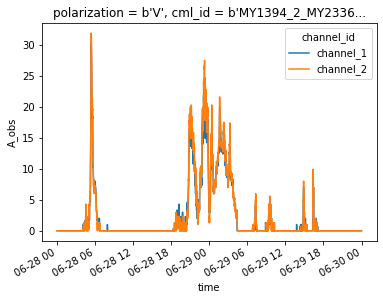

In [26]:
cml['A_obs'] = (cml.trsl - cml.baseline)
cml['A_obs'] = cml.A_obs.where(cml.A_obs >=0, 0)
cml.A_obs.plot.line(x='time');

In [27]:
# TODO: Allow to pass several channels and handle the required 1D array of frequencies
cml['waa'] = ('channel_id', 'time'), np.stack([
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
        A_obs=cml_ch.A_obs.values, 
        f_Hz=cml_ch.frequency.values*1e9, 
        L_km=cml_ch.length.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

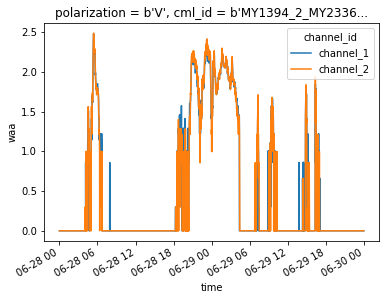

In [28]:
cml.waa.plot.line(x='time');

In [81]:
# Tried the WIP decorrator here as a function, but this does not work because 
# the function called insided would also need to be wrapped
waa_leijnse_2008_from_A_obs = xarray_loop_vars_over_dim(vars_to_loop=['A_obs', 'f_Hz'], loop_dim='channel_id')(
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs
)

waa_leijnse_2008_from_A_obs(
    A_obs=cml.A_obs.values, 
    f_Hz=cml.frequency.values*1e9, 
    L_km=cml.length.values,driv
)

NameError: name 'xarray_loop_vars_over_dim' is not defined

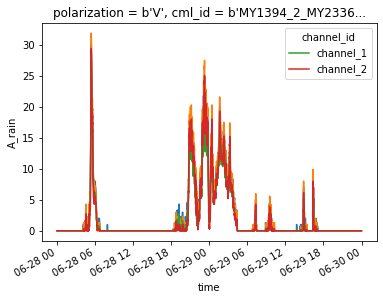

In [30]:
cml['A_rain'] = cml.A_obs - cml.waa
cml.A_obs.plot.line(x='time');
cml.A_rain.plot.line(x='time');

In [31]:
# TODO: Same as above, but also make units of L and f consistenst
cml['R'] = ('channel_id', 'time'), np.stack([
    pycml.processing.k_R_relation.calc_R_from_A(
        A=cml_ch.A_obs.values, 
        L=cml_ch.length.values,
        f_GHz=cml_ch.frequency.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

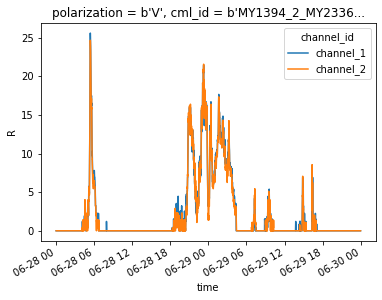

In [32]:
cml.R.plot.line(x='time');

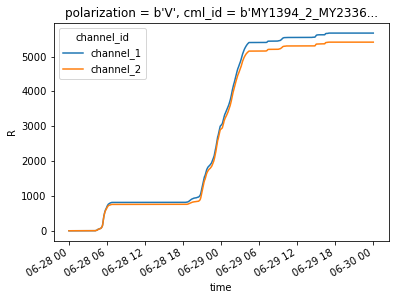

In [33]:
cml.R.cumsum(dim='time').plot.line(x='time');

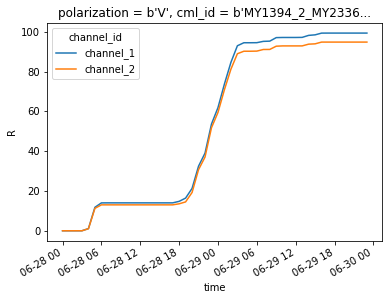

In [34]:
cml.R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time');

In [35]:
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 2750)
Coordinates:
    polarization      |S1 b'V'
    cml_id            |S17 b'MY1394_2_MY2336_4'
    length            float64 13.48
    site_b_latitude   float64 50.38
    site_a_latitude   float64 50.26
    site_a_longitude  float64 50.91
    site_b_longitude  float64 50.38
  * time              (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ... 2017-06-29T23:59:10.229434880
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (channel_id) float64 18.2 19.2
Data variables:
    tsl               (channel_id, time) float64 14.0 14.0 14.0 ... 14.0 13.0
    rsl               (channel_id, time) float64 -47.0 -47.0 ... -47.0 -47.0
    trsl              (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    wet               (channel_id, time) bool False False False ... False False
    baseline          (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    A_obs             (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waa               (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    A_rain            (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R                 (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0